In [1]:
%%writefile CenterLoss.py
import torch
import torch.nn as nn
from torch.autograd.function import Function

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss


class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None


def main(test_cuda=False):
    print('-'*80)
    device = torch.device("cuda" if test_cuda else "cpu")
    ct = CenterLoss(10,2,size_average=True).to(device)
    y = torch.Tensor([0,0,2,1]).to(device)
    feat = torch.zeros(4,2).to(device).requires_grad_()
    print (list(ct.parameters()))
    print (ct.centers.grad)
    out = ct(y,feat)
    print(out.item())
    out.backward()
    print(ct.centers.grad)
    print(feat.grad)

if __name__ == '__main__':
    torch.manual_seed(999)
    main(test_cuda=False)
    if torch.cuda.is_available():
        main(test_cuda=True)

Writing CenterLoss.py


     |████████████████████████████████| 109 kB 351 kB/s            
--2022-04-07 11:22:24--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-04-07 11:22:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  6.43MB/s    in 5.9s    

2022-04-07 11:22:32 (5.62 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


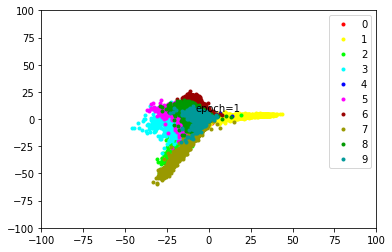

Training... Epoch = 2


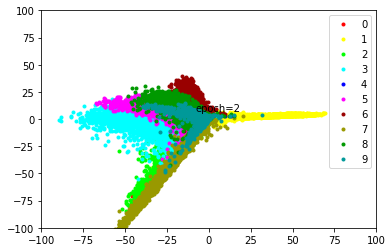

Training... Epoch = 3


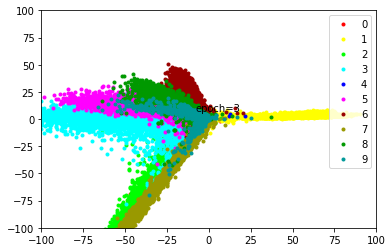

Training... Epoch = 4


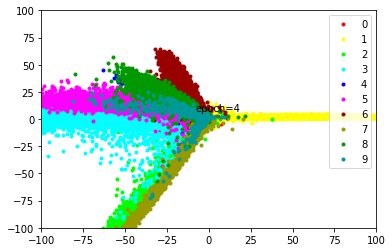

Training... Epoch = 5


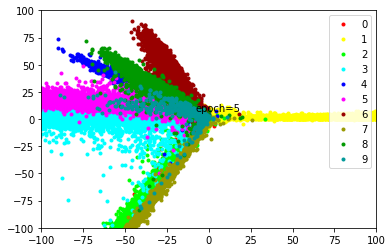

Training... Epoch = 6


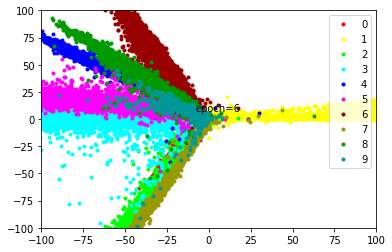

Training... Epoch = 7


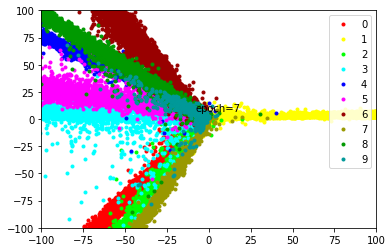

Training... Epoch = 8


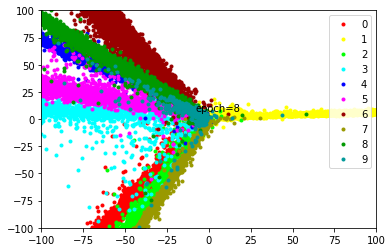

Training... Epoch = 9


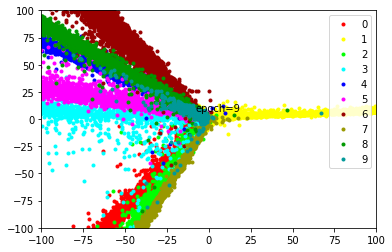

Training... Epoch = 10


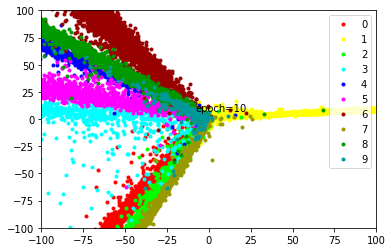

Training... Epoch = 11


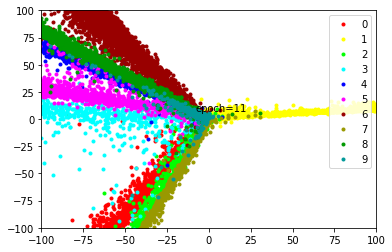

Training... Epoch = 12


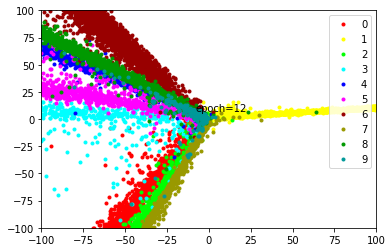

Training... Epoch = 13


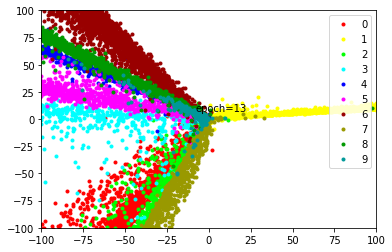

Training... Epoch = 14


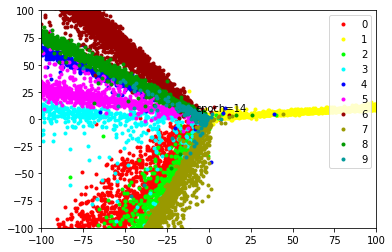

Training... Epoch = 15


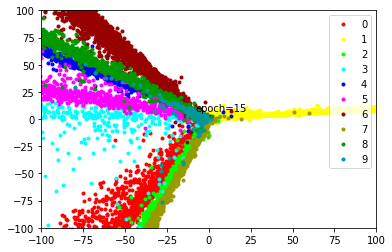

Training... Epoch = 16


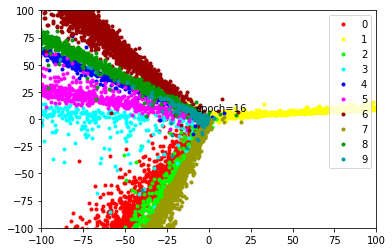

Training... Epoch = 17


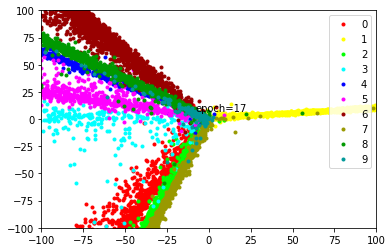

Training... Epoch = 18


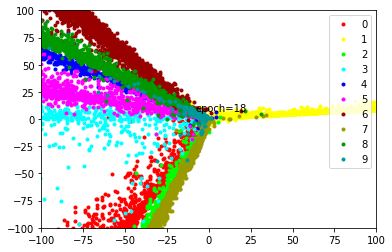

Training... Epoch = 19


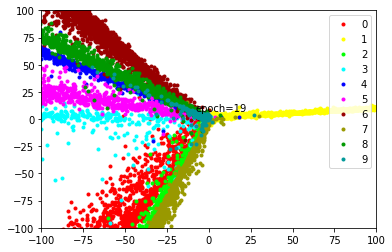

Training... Epoch = 20


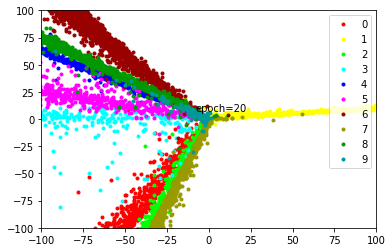

Training... Epoch = 21


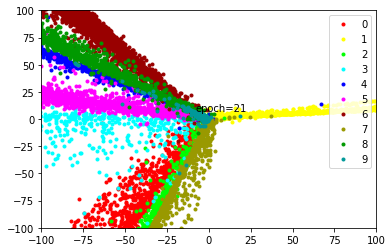

Training... Epoch = 22


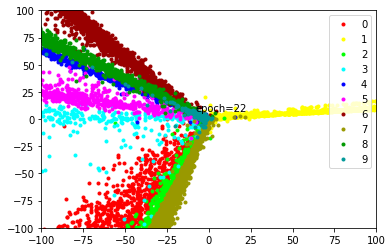

Training... Epoch = 23


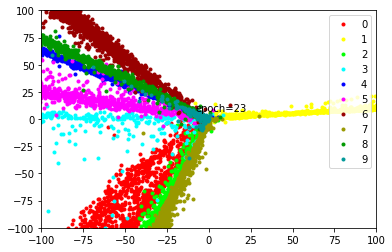

Training... Epoch = 24


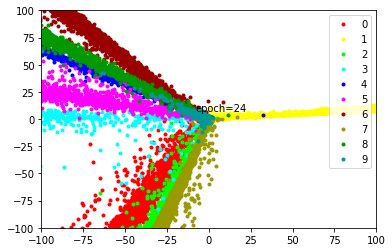

Training... Epoch = 25


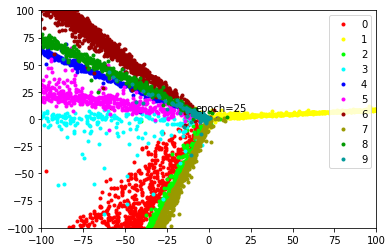

Training... Epoch = 26


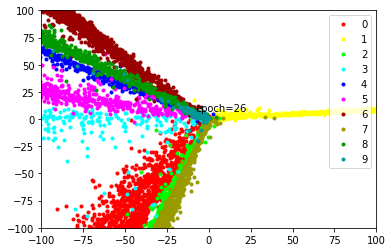

Training... Epoch = 27


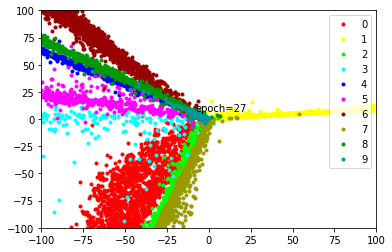

Training... Epoch = 28


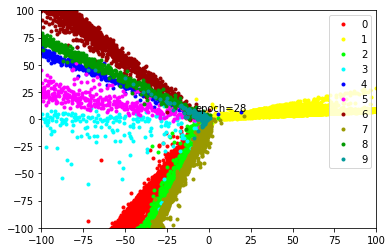

Training... Epoch = 29


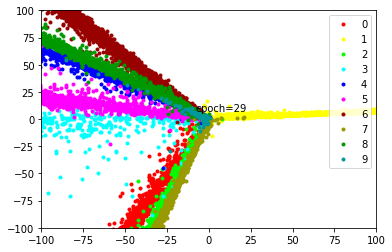

Training... Epoch = 30


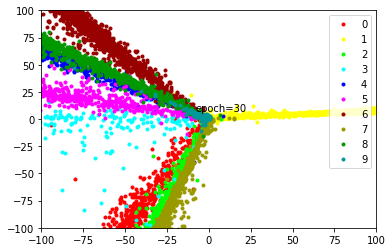

Training... Epoch = 31


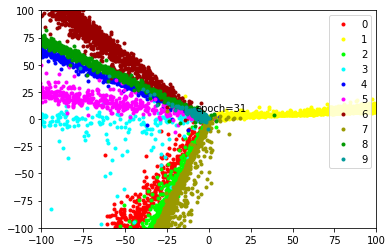

Training... Epoch = 32


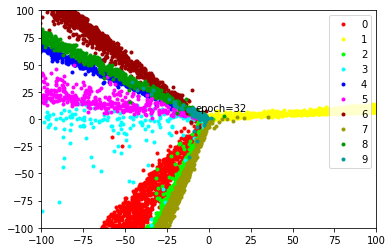

Training... Epoch = 33


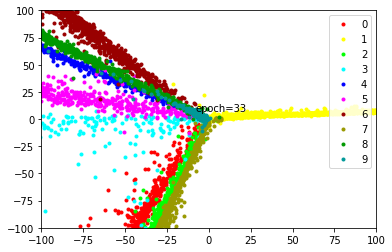

Training... Epoch = 34


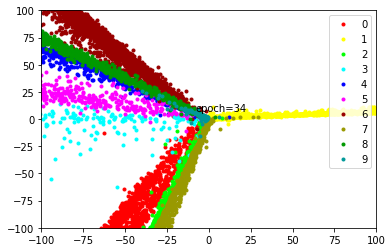

Training... Epoch = 35


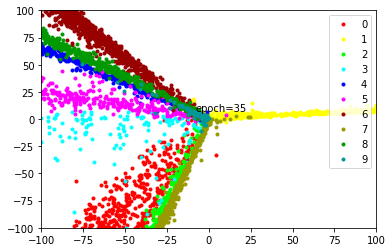

Training... Epoch = 36


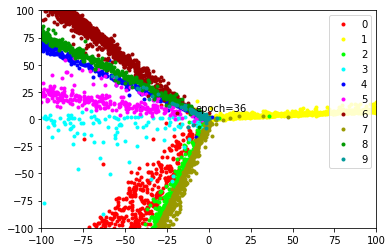

Training... Epoch = 37


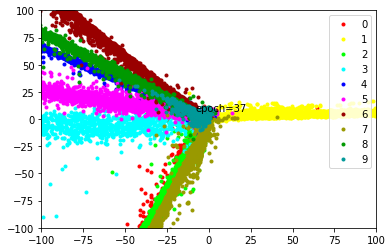

Training... Epoch = 38


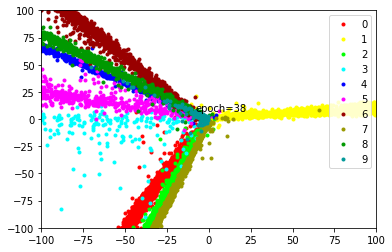

Training... Epoch = 39


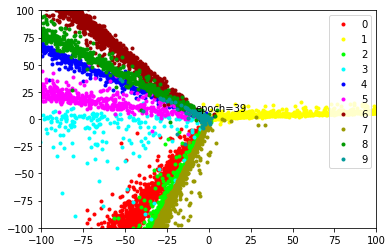

Training... Epoch = 40


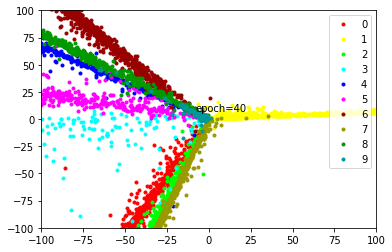

Training... Epoch = 41


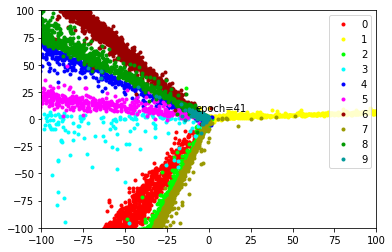

Training... Epoch = 42


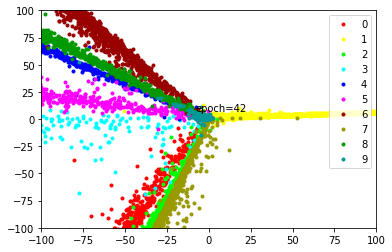

Training... Epoch = 43


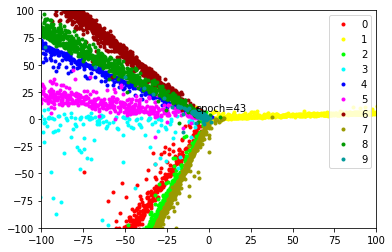

Training... Epoch = 44


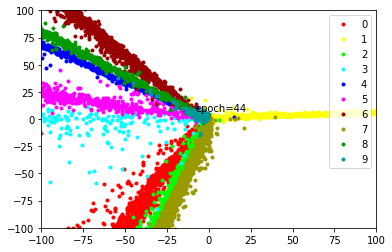

Training... Epoch = 45


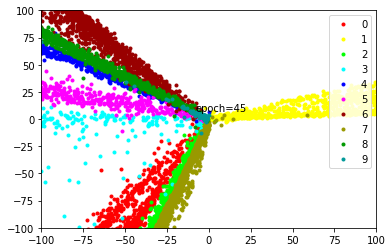

Training... Epoch = 46


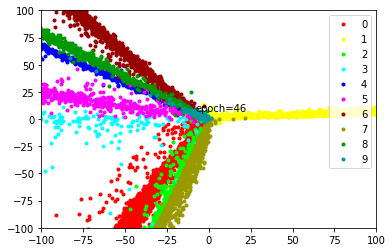

Training... Epoch = 47


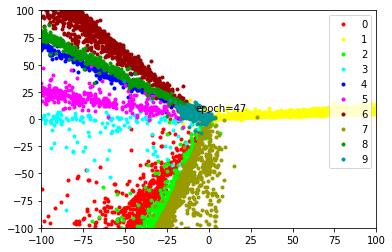

Training... Epoch = 48


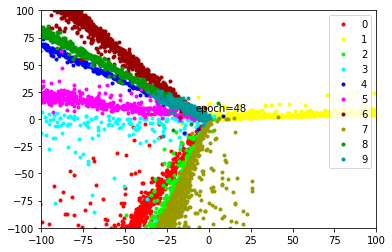

Training... Epoch = 49


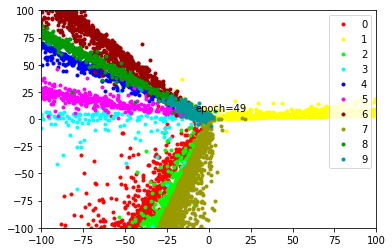

Training... Epoch = 50


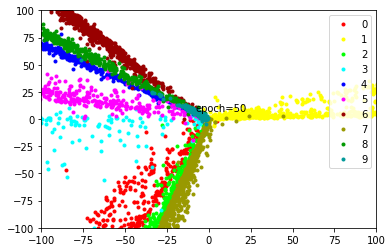

In [2]:
# ArcFace Loss
!pip install pytorch_metric_learning
import pytorch_metric_learning 
from pytorch_metric_learning import losses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128*3*3, 2)
        self.ip2 = nn.Linear(2, 10, bias=False)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 128*3*3)
        ip1 = self.preluip1(self.ip1(x))
        ip2 = self.ip2(ip1)
        # return log_softmax是否有问题
        #return ip1, F.log_softmax(ip2, dim=1)
        return ip1,F.log_softmax(ip2,dim=1)
    
def visualize(feat, labels, epoch):
    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    plt.clf()
    for i in range(10):
        plt.plot(feat[labels == i, 0], feat[labels == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
    plt.xlim(xmin=-100,xmax=100)
    plt.ylim(ymin=-100,ymax=100)
    plt.text(-7.8,7.3,"epoch=%d" % epoch)
    #plt.savefig('./images/epoch=%d.jpg' % epoch)
    plt.draw()
    plt.pause(0.001)

def train(epoch):
    print ("Training... Epoch = %d" % epoch)
    ip1_loader = []
    idx_loader = []
    for i,(data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        ip1, pred = model(data)
        #loss = nllloss(pred, target) + loss_weight * centerloss(target, ip1)
        loss = loss_weight_1 * nllloss(pred, target) + loss_weight_2 * arcfaceloss(pred,target) 
        optimizer.zero_grad()
        optimizer4nn.zero_grad()

        loss.backward()
        
        optimizer.step()
        optimizer4nn.step()

        ip1_loader.append(ip1)
        idx_loader.append((target))

    feat = torch.cat(ip1_loader, 0)
    labels = torch.cat(idx_loader, 0)
    visualize(feat.data.cpu().numpy(),labels.data.cpu().numpy(),epoch)

use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
import torchvision
import torchvision.transforms as transforms
root_dir = './'
trainset = datasets.MNIST(root=root_dir, download=True,train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)     

# Model
model = Net().to(device)

# Loss
nllloss = nn.NLLLoss().to(device) #CrossEntropyLoss = log_softmax + NLLLoss
arcfaceloss = losses.ArcFaceLoss(num_classes=10,embedding_size=10).to(device)

# Loss_combine
loss_weight_1 = 0.8
loss_weight_2 = 0.2


# optimzer
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9, weight_decay=0.0005)
optimizer4nn = torch.optim.Adam(model.parameters(),lr=5e-5)
sheduler = lr_scheduler.StepLR(optimizer4nn,20,gamma=0.8)

for epoch in range(50):
    sheduler.step()
    # print optimizer4nn.param_groups[0]['lr']
    train(epoch+1)